In [1]:
import numpy as np
import random
import copy
import math
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

fittest_swarm = None
num_drones = 1
drone_id = 0
population = []
map_length = 50
map_width = 50
generations = 100
battery_life = (map_length * map_width)/num_drones
members_per_generation = 1

In [2]:
# Class to represent a drone.
# id - drone's numerical ID
# x, y - coordinates of where the drone is
# x_move, y_move - the outputs of the neural network that control the direction the drones move
# coverage - the radius of the circular search area that the drone covers
# rely_on - the drone that self relies on for positioning. If the signal with this drone is too weak, self "dies"
# send_to - the drone that relies on self for positioning
# connected_to - list of drones that self is connected to
# is_alive - "alive" (True) when self is close enough to rely_on for signal, "dead" (False) otherwise
# nn - the neural network of this drone
class Drone:
    id = 0
    x = 0
    y = 0
    x_move = 0
    y_move = 0
    unsearched_N = 0
    unsearched_S = 0
    unsearched_W = 0
    unsearched_E = 0
    coverage = 3
    rely_on = None
    send_to = None
    connected_to = []
    is_alive = True
    nn = None
    swarm = None # drone knows what swarm it belongs to
    
    # Initialize self variables
    def __init__(self):
        # Assign self id
        global drone_id
        self.id = drone_id
        drone_id += 1
        
        # Instantiate other self vars
        self.connected_to = []
        self.rely_on = None
        self.send_to = None
        self.nn = None
        self.swarm = None
        
        self.unsearched_N = 1
        self.unsearched_S = 1
        self.unsearched_W = 1
        self.unsearched_E = 1
        
    # When printing drone object, it prints the drone's numerical id
    def __repr__(self):
        return str(self.id)
    
    # Create and initialize the neural network
    def neural_init(self):
        self.nn = NeuralNetwork(self.get_input_layer())
    
    # Interprets what the input layer for the neural network should be at the time the func is called
    def get_input_layer(self):
        # Gets the signal strength between important drone connections. -1 if connection doesn't exist
        rely_on_sig = -1
        #print(self, "relies on", self.rely_on)
        if self.rely_on != None:
            rely_on_sig = drone_sig_strength(self, self.rely_on)
        
        #print(self, "sends to", self.send_to)
        send_to_sig = -1
        if self.send_to != None:
            send_to_sig = drone_sig_strength(self, self.send_to)
        
        self.sense_surroundings()
        
        # Assembles the input layer using variables.
        in_layer = [self.x, self.y, rely_on_sig, send_to_sig, self.x_move, self.y_move, self.unsearched_N*50, self.unsearched_S*50, self.unsearched_E*50, self.unsearched_W*50]
        #in_layer = [self.x, self.y, rely_on_sig, send_to_sig, self.x_move, self.y_move]
        #in_layer = [sigmoid(self.x*5), sigmoid(self.y*5), sigmoid(rely_on_sig), sigmoid(send_to_sig), self.x_move, self.y_move]
        #out_layer_form = np.array([[0],[0],[0],[0]])
        in_layer = np.array([in_layer])
        #self.nn = NeuralNetwork(in_layer, out_layer_form)
        return in_layer
    
    # Feedforward the neural network. aka Find the output layer given an input_layer
    # Get input layer from get_input_layer()
    def neural_net_feedforward(self, input_layer):
        #print(input_layer)
        movement = self.nn.feedforward(input_layer)
        #print(self, movement)
        self.x_move = movement[0][0]
        self.y_move = movement[0][1]
        
    def sense_surroundings(self):
        sense = self.coverage + 1
        if int(self.x) + sense <= self.swarm.the_map.length and not self.swarm.the_map.search_points[int(self.x) + sense][int(self.y)][0]:
            self.unsearched_E = 1
        else:
            self.unsearched_E = 0
            
        if int(self.x) - sense >= 0 and not self.swarm.the_map.search_points[int(self.x) - sense][int(self.y)][0]:
            self.unsearched_W = 1
        else:
            self.unsearched_W = 0
            
        if int(self.y) + sense <= self.swarm.the_map.width and not self.swarm.the_map.search_points[int(self.x)][int(self.y) + sense][0]:
            self.unsearched_N = 1
        else:
            self.unsearched_N = 0
            
        if int(self.y) - sense >= 0 and not self.swarm.the_map.search_points[int(self.x)][int(self.y) - sense][0]:
            self.unsearched_S = 1
        else:
            self.unsearched_S = 0

In [3]:
# Function to turn any number into a number between 0 and 1
# Use a sine function because other functions didn't have enough variation in the output
# https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6 
def sigmoid(x):
    #print(x, '\n')
    #return 2*((1.0/(1+ np.exp(-0.5*(x-1)))-0.5))
    #return (np.sin(x)+1)*.5
    return np.sin(math.pi * x - math.pi/2) * .5 +.5
    #return ((np.tanh(.05*(x-50))+1)*.5)

# Neural network class
class NeuralNetwork:
    # Weights between layers are randomly created
    def __init__(self, x):
        self.input      = x
        # 4 layers, 6 -> 4 -> 8 -> 2
        self.weights = [None] * 3
        self.weights[0]   = np.random.rand(self.input.shape[1], 4)
        self.weights[1]   = np.random.rand(4, 7)  
        self.weights[2]   = np.random.rand(7, 2)  
        
        #self.output = np.zeros(y.shape)
    
    # Input layer is fedforward through the nn and output layer is calculated
    def feedforward(self, input_layer):
        self.hidden_layers = [None] * 2
        #For simplicity, biases are assumed to be zero
        self.hidden_layers[0] = sigmoid(np.dot(input_layer, self.weights[0]))
        self.hidden_layers[1] = sigmoid(np.dot(self.hidden_layers[0], self.weights[1]))
        self.output = sigmoid(np.dot(self.hidden_layers[1], self.weights[2]))
        #print(self.output)
        return self.output

In [4]:
# used to get starting points for drones.
# n - number of drones/points
# r - radius of polygon/how far spread out they should be
# map_size - the size of the map the points will be plotted on (to put tha points in the center)
# returns - vertices, which is a 2 element long array. 
#    Element [0] is an array of all the x-component of points
#    Element [1] is an array of all the y-component of points
#    The same indices in each x and y list represent different components of the same point
#    Example: point 2's x value is at x[2] and the y value is at y[2]
def vertices_of_regpoly(n, r, map_length, map_width):
    vertices = []
    x = []
    y = []
    for i in range(0, n):
        #x.append(( map_length / 2) + r * math.cos(2 * math.pi * i / n))
        #y.append(( map_width / 2) + r * math.sin(2 * math.pi * i / n))
        x.append(3 + r * math.cos(2 * math.pi * i / n))
        y.append(3 + r * math.sin(2 * math.pi * i / n))
    vertices.append(x)
    vertices.append(y)
    return vertices

In [5]:
# Set each drone's initial locations to the drone's self.x and self.y values
def set_init_drones(swarm):
    xy = vertices_of_regpoly(num_drones, 2, swarm.the_map.length, swarm.the_map.width)
    for i in range(0, len(swarm.drones)):
        swarm.drones[i].x = xy[0][i]
        swarm.drones[i].y = xy[1][i]
        swarm.drones[i].x_move = 0
        swarm.drones[i].y_move = 0
        swarm.drones[i].is_alive = True
        swarm.drones[i].swarm = swarm

In [6]:
# The swarm class is a collection of drones
# It is also the "organism" unit of the population list, used in the Genetic Algorithm component of the program
# drones - list of drones in the population
# connectedness - matrix representing how the drones are connected to each other
class Swarm:
    drones = []
    connectedness = []
    fitness = 0
    battery_life = 0 # simulates a time limit to search an area
    battery_left = 0
    
    # Initialize the swarm
    def __init__(self, drones, map_length, map_width):
        global battery_life
        self.battery_life = battery_life
        self.battery_left = self.battery_life
        self.fitness = 0
        self.the_map = GeoMap(map_length, map_width) # The map to search
        self.drones = drones # the list of drones
        global drone_id # Reset the drone id counter for every swarm 
        drone_id = 0
        set_init_drones(self) # Set each drone's initial locations
        self.assign_connectedness()
        self.assign_drone_connect()
        self.rssi_table = []
        determine_architecture(self)
        determine_neighbors(self)
        for drone in self.drones:
            drone.neural_init()
    
    def __repr__(self):
        return str(self.fitness)
    
    def reset(self):
        self.battery_left = self.battery_life
        self.fitness = 0
        self.the_map = GeoMap(map_length, map_width) # The map to search
        set_init_drones(self) # Set each drone's initial locations
            
    # Randomly assign how the drones are connected to each other
    def assign_connectedness(self):
        #Make the swarm's connectivity matrix
        #This matrix is really only used for initial configuration
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        self.connectedness = np.zeros((len(self.drones),len(self.drones)))

        #The upper traingle of a mtrix w/o diagonal is filled in with 1s
        #the diagonal would mean drones are connected to themselves
        #the lower triangle is just a reflection
        #representation of the connections between drones
        for i in range(0,len(self.drones)):
            for j in range(0, i):
                self.connectedness[j][i] = 1

        # Ensure that each drone has at least one connection
        for i in range(0,len(self.drones)):
            possible_values = np.nonzero(self.connectedness[i])[0].tolist()
            choice = random.choice(possible_values) if possible_values else -1
            if choice != -1:
                possible_values.remove(choice)
            #Remaining choices have a possibility of not being connections (probability related to the number of drones)
            for value in possible_values:
                self.connectedness[i][value] = 0 if random.random() > 1.0/float(len(self.drones)) else 1

        #reflect over diagonal axis of matrix to make symmetric matrix
        for i in range(0,len(self.drones)):
            for j in range(0, i):
                self.connectedness[i][j] = self.connectedness[j][i]
    
    # After the swarm's connectedness is determines, each drone is told which drones it is connected to
    def assign_drone_connect(self):
        #Assign list connectedness in drones
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        for i in range(0,len(self.connectedness)):
            for j in range(0, len(self.connectedness)):
                if self.connectedness[i][j] == 1:
                    self.drones[i].connected_to.append(self.drones[j])
    
    # Determine the fitness of the swarm for purposes of evolution
    # Fitness is determined by how much of the map the swarm could cover in its battery life
    #def determine_fitness(self):
        #num_points_searched = 0
        #for x in range(0, len(self.the_map.search_points)):
            #for y in range(0, len(self.the_map.search_points[x])):
                  #if self.the_map.search_points[x][y]:
                    #num_points_searched += 1
        #fitness = float(num_points_searched)/float(self.the_map.size)
        #return fitness
        #return float(num_points_searched)/float(self.the_map.size)
    
    def search_percentage(self):
        return float(self.fitness)/float(self.the_map.get_total_points()) * 100

In [7]:
# This map class represents a geographical area that must be searched by a  swarm
# search_points - points in the map that will be checked if they have been searched or not. Represented by a matrix of booleans
class GeoMap:
    search_points = []
    #searched_points = set() # NOT CURRENTLY USED
    # Was explored as an alternative method to search points. Was just a list of points of where drones have been.
    def __init__(self, length, width):
        self.length = length
        self.width = width
        self.search_points = []
        self.populate_search_points()
    
    # Create a visualization of the map border
    def draw_map(self):
        plt.plot([0, 0,          self.length, self.length, 0], 
                 [0, self.width, self.width,  0,           0])
        self.disp_search_points()
        #self.disp_searched_points()
    
    # Create a visualization of which points in search_points have been searched
    def disp_search_points(self):
        for x in range(0, len(self.search_points)):
            for y in range(0, len(self.search_points[x])):
                if self.search_points[x][y][0]:
                    plt.plot(x, y, '.', color=self.search_points[x][y][1])
    
    # NOT CURRENTLY USED
    #def disp_searched_points(self):
        #for point in self.searched_points:
            #plt.plot(point[0], point[1], '.', color='green')
    
    # Initialize the map of search points
    def populate_search_points(self):
        for i in range(0, self.length + 2):
            row = []
            for j in range(0, self.width + 2):
                row.append([False, '#00FF00'])
            self.search_points.append(row)
            
    def get_total_points(self):
        return self.length * self.width

In [8]:
# Determine the architecture of the swarm in terms of which drone relies on which for positioning and communication
# Architecture is determined maximize the signal strength read between drones 
# (drones farther away from each other initially will not attempt to talk to each other directly)
def determine_architecture(swarm):
    coordinator = None
    for drone in swarm.drones:
        if coordinator == None:
            coordinator = drone
            rssi = 0
        else:
            rssi = drone_sig_strength(drone, coordinator)
        init_rssi_table(drone, rssi, swarm.rssi_table)
    sort_table_by_rssi(swarm.rssi_table)

In [9]:
# Initialize the signal strength table
def init_rssi_table(node_check, rssi, rssi_table):
    node = {}
    node["node"] = node_check
    node["rssi"] = rssi
    rssi_table.append(node)

In [10]:
# Sort the signal strength table
def sort_table_by_rssi(rssi_table):
    rssi_table.sort(key=lambda val: val["rssi"])

In [11]:
# Drones determine who they should rely_on for communication and who they should send_to 
# This is determined based o nthe ordering of the sorted signal-strength-architecture table
def determine_neighbors(swarm):
    if len(swarm.rssi_table) > 1:
        for index in range(0, len(swarm.rssi_table)):
            node = swarm.rssi_table[index]['node']
            if index == 0:
                node.rely_on = None
                node.send_to = swarm.rssi_table[index + 1]['node']
            elif index == len(swarm.rssi_table) - 1:
                node.rely_on = swarm.rssi_table[index - 1]['node']
                node.send_to = None
            else:
                node.rely_on = swarm.rssi_table[index - 1]['node']
                node.send_to = swarm.rssi_table[index + 1]['node']

In [12]:
# Create a starting population (generation 1) for the genetic algorithm
# size - how many members of the population should be created
# map_size - the size of the map of the world that the population should be simulated in
def create_starting_population(size, map_length, map_width):
    population = []
    
    global num_nodes
    for i in range(0,size):
        population.append(create_new_member([], map_length, map_width))
        
    return population

In [13]:
# Creates a new member of a population
# drones - list of drones for the population-member (swarm) (if list empty, drones will be created)
# map_size - the size of the map of the world that the population should be simulated in
def create_new_member(drones, map_length, map_width):
    if drones == []:
        global num_drones
        for i in range(0, num_drones):
            drones.append(Drone())
    member = Swarm(drones, map_length, map_width)
    return member

In [14]:
# Display a visualization of a swarm
def plot_swarm(swarm):
    fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
    for drone in swarm.drones:
        plt.plot(drone.x, drone.y, 'x', color='black')
        #print(drone.x, drone.y)
        circle1 = plt.Circle((drone.x, drone.y), drone.coverage, color = 'b', fill=False)        
        ax.add_artist(circle1)

    #fig.savefig('plotcircles.png')
        
    # Draws a visualization for the network connections    
    for row in range(0, num_drones - 1):
        for col in range(row + 1, num_drones):
            if swarm.connectedness[row][col] == 1:
                plt.plot([swarm.drones[row].x, swarm.drones[col].x], 
                         [swarm.drones[row].y, swarm.drones[col].y])

In [15]:
# Returns all the integer points that are within a given circle
# x0, y0 - the center of the circle
# radius - the radius of the circle
# NOT USED CURRENTLY
def points_in_circle(x0, y0, radius):
    x_ = np.arange(x0 - radius - 1, x0 + radius + 1, dtype=int)
    y_ = np.arange(y0 - radius - 1, y0 + radius + 1, dtype=int)
    x, y = np.where((x_[:,np.newaxis] - x0)**2 + (y_ - y0)**2 <= radius**2)
    # x, y = np.where((np.hypot((x_-x0)[:,np.newaxis], y_-y0)<= radius)) # alternative implementation
    for x, y in zip(x_[x], y_[y]):
        yield x, y
        plt.plot(x, y, '.', color='blue')

In [16]:
# Determine the distance between two drones
def drone_distance(drone1, drone2):
    return abs(math.hypot(drone2.x - drone1.x, drone2.y - drone1.y))

# Determine the signal strength between 2 drones using an RSSI formula
def drone_sig_strength(drone1, drone2):
    #return 20*math.log10(1/math.pow(drone_distance(drone1, drone2),2))
    #return 1/math.pow(drone_distance(drone1, drone2),2)
    dist = drone_distance(drone1, drone2)
    #print(dist)
    try:
        return  10*2*math.log10(dist) + 1
    except ValueError:
        return 0

# Determine the signal strength between all drones of an entire swarm
def swarm_sig_strength(swarm):
    swarm_strength = []
    
    for i in range(0, num_drones):
        for j in range(0, i):
            if swarm.connectedness[i][j] == 1:
                #print('Signal strength between drone ', i, ' and drone ', j, ': ', end='')
                #print(drone_sig_strength(swarm.drones[i], swarm.drones[j]))
                dist = drone_distance(swarm.drones[i], swarm.drones[j])
                sig_strength = drone_sig_strength(swarm.drones[i], swarm.drones[j])
                swarm_strength.append([[j, i], dist , sig_strength])
    return swarm_strength

In [17]:
# Check how many points in GeoMap's search_points have been searched
def check_drone_coverage(swarm):
    #Only check the points that are within the area that drones have been
    min_x = swarm.the_map.length + 1
    max_x = 0
    min_y = swarm.the_map.width + 1
    max_y = 0
    for drone in swarm.drones:
        if drone.x < min_x:
            min_x = drone.x
        if drone.x > max_x:
            max_x = drone.x
        if drone.y < min_y:
            min_y = drone.y
        if drone.y > max_y:
            max_y = drone.y
    
        #for circle_point in points_in_circle(drone.x, drone.y, drone.coverage):
            #the_map.searched_points.add(circle_point)
    
    #Check if points are within drone coverage
    for x in range(int(min_x - drone.coverage), int(max_x + drone.coverage) + 1):
        for y in range(int(min_y - drone.coverage), int(max_y + drone.coverage) + 1):
            for drone in swarm.drones:
                dist = math.sqrt(math.pow(x-drone.x, 2) + math.pow(y-drone.y, 2))
                if dist <= drone.coverage:
                    if x >= 0 and x <= swarm.the_map.length and y >= 0 and y <= swarm.the_map.width:
                        if not swarm.the_map.search_points[x][y][0]:
                            swarm.fitness += 1
                        swarm.the_map.search_points[x][y][0] = True
                        color = math.floor((swarm.battery_left/swarm.battery_life) * 255)
                        if color < 16:
                            swarm.the_map.search_points[x][y][1] = '#000' + str(hex(color))[2:] + '00'
                        else:
                            swarm.the_map.search_points[x][y][1] = '#00' + str(hex(color))[2:] + '00'

    #print(swarm_sig_strength(swarm))
    #print(the_map.search_points)
        

In [18]:
def search_area_limits(swarm):
    #Only check the points that are within the area that drones have been
    min_x = swarm.the_map.size + 1
    max_x = 0
    min_y = swarm.the_map.size + 1
    max_y = 0
    for drone in swarm.drones:
        if drone.x < min_x:
            min_x = drone.x
        if drone.x > max_x:
            max_x = drone.x
        if drone.y < min_y:
            min_y = drone.y
        if drone.y > max_y:
            max_y = drone.y
    return min_x, max_x, min_y, max_y

In [19]:
def check_coverage_population():
    for swarm in population:
        check_drone_coverage(swarm)

In [20]:
# Create a visualization of a swarm and the map it has searched
# swarm - the swarm to display
def draw_scene(swarm):
    plot_swarm(swarm)
    swarm.the_map.draw_map()
    print(swarm.search_percentage(), '%')

In [21]:
def plot_population():
    for swarm in population:
        draw_scene(swarm)
        #print(sorted(the_map.searched_points))
        #print(swarm_sig_strength(swarm))
        #print(swarm.fitness)
        #print(swarm.determine_fitness())

In [22]:
# Initialization of the main program
def init():
    global population
    global map_length
    global map_width
    global members_per_generation
    population = create_starting_population(members_per_generation, map_length, map_width)
    check_coverage_population()
    #plot_population()
    #for swarm in population:
        #determine_architecture(swarm)
        #determine_neighbors(swarm)

In [23]:
# Drones randomly move around with no intelligence to attempt to search an area
def scatter():
    for swarm in population:
        while swarm.battery_left > 0:
            for drone in swarm.drones:
                if drone.is_alive:
                    x_adj = 0
                    y_adj = 0
                    x_adj += random.randint(-1, 1)
                    y_adj += random.randint(-1, 1)
                    #for circle_point in points_in_circle(drone.x, drone.y, drone.coverage):
                        #print(circle_point)
                        #the_map.searched_points.add(circle_point)
                   
                    #if drone.x < 0 or drone.x > swarm.the_map.size or drone.y < 0 or drone.y > swarm.the_map.size:
                        #drone.is_alive = False
                        
                    # Move the drone based on the nn results
                    if drone.x + x_adj >= 0 and drone.x + x_adj <= swarm.the_map.length:
                        drone.x += x_adj
                    if drone.y + y_adj >= 0 and drone.y + y_adj <= swarm.the_map.width:
                        drone.y += y_adj

                    check_drone_coverage(swarm)
                    
                    # If the drone strayed too far away from it's neighbor's, the drone is dead
                    if drone.rely_on != None and drone_sig_strength(drone, drone.rely_on) > 30:
                        drone.is_alive = False

                    if drone.send_to != None and drone_sig_strength(drone, drone.send_to) > 30:
                        drone.is_alive = False
                        
                    #for neighbor in drone.connected_to:
                        #if drone_sig_strength(drone, neighbor) > 30:
                            #drone.is_alive = False
            swarm.battery_left -= 1 

In [24]:
# Drones move around via neural network results to attempt to search an area
def smart_scatter():
    for swarm in population:
        while swarm.battery_left > 0:
            for drone in swarm.drones: 
                if drone.is_alive:
                    # Interpret neural network results
                    if drone.x_move < 0.33:
                        x_adj = -1
                    elif drone.x_move >= 0.33 and drone.x_move < .66:
                        x_adj = 0
                    elif drone.x_move >= .66:
                        x_adj = 1

                    if drone.y_move < 0.33:
                        y_adj = -1
                    elif drone.y_move >= 0.33 and drone.y_move < .66:
                        y_adj = 0
                    elif drone.y_move >= .66:
                        y_adj = 1

                    # Move the drone based on the nn results
                    if drone.x + x_adj >= 0 and drone.x + x_adj <= swarm.the_map.length:
                        drone.x += x_adj
                    if drone.y + y_adj >= 0 and drone.y + y_adj <= swarm.the_map.width:
                        drone.y += y_adj
                    
                    # Update the search_points to see if any more have been searched
                    check_drone_coverage(swarm)
                    #for circle_point in points_in_circle(drone.x, drone.y, drone.coverage):
                        #print(circle_point)
                        #the_map.searched_points.add(circle_point)

                    # If the drone left the map, drone is dead
                    #if drone.x < 0 or drone.x > swarm.the_map.size or drone.y < 0 or drone.y > swarm.the_map.size:
                        #drone.is_alive = False

                    # If the drone strayed too far away from it's neighbor's, the drone is dead
                    if drone.rely_on != None and drone_sig_strength(drone, drone.rely_on) > 30:
                        drone.is_alive = False

                    if drone.send_to != None and drone_sig_strength(drone, drone.send_to) > 30:
                        drone.is_alive = False
                        
                    #for neighbor in drone.connected_to:
                        #if drone_sig_strength(drone, neighbor) > 30:
                            #drone.is_alive = False

                    drone.neural_net_feedforward(drone.get_input_layer())
            swarm.battery_left -= 1 

In [25]:
def hard_coded_search():
    for swarm in population:
            for drone in swarm.drones:
                d = 1
                batteryyy = map_length * map_width
                while (batteryyy > 0):
                    batteryyy -= 1
                    if d == 1 and drone.x < map_length:
                        drone.x += 1
                    if d == 1 and drone.x == map_length:
                        drone.y += 1
                        d = -1
                    if d == -1 and drone.y > 0:
                        drone.x -= 1
                    if d == -1 and drone.x == 0:
                        drone.y += 1
                        d = 1
                    check_drone_coverage(swarm)     

In [26]:
def kill_off_the_weak():
    for unfortunate_soul in range(math.floor(len(population)/2), len(population)):
        population.pop()

In [27]:
def check_for_fittest():
    global fittest_swarm
    if fittest_swarm == None or population[0].fitness > fittest_swarm.fitness:
        fittest_swarm = copy.deepcopy(population[0])
        check_drone_coverage(fittest_swarm)
        draw_scene(fittest_swarm)
    #print("Fittest's fitness", fittest_swarm.fitness)
    
        print(datetime.datetime.now() - start_time)
        return True
    else:
        return False

In [28]:
# GA function to mate/breed organisms of the population together
# Done so by swapping drones with each other
def mingle_the_genes():
    global population
    
    # Assigning metaphorical sex. M/F assignment only metaphorical for separating groups
    males = []
    females = []
    
    random.shuffle(population)
    for i in range(0, len(population), 2):
        males.append(population[i])
    for i in range(1, len(population), 2):
        females.append(population[i])

    if len(females) == 0:
        asexually_reproduce()
        
    else:
        for i in range(0, len(females)): #because females list will be shorter

            splice_site = random.randint(1, len(females[i].drones))

            males_front = males[i].drones[:splice_site]
            males_end   = males[i].drones[splice_site:]
            females_front = females[i].drones[:splice_site]
            females_end   = females[i].drones[splice_site:]

            offspring0_drones = copy.deepcopy(females_front + males_end)
            offspring1_drones = copy.deepcopy(males_front + females_end)

            population.append(create_new_member(offspring0_drones, map_length, map_width))
            population.append(create_new_member(offspring1_drones, map_length, map_width))
        

In [29]:
#Reset swarm population
def reset_population():
    for swarm in population:
        swarm.reset()

In [30]:
def mutate_population():
    global population
    for swarm in population:
        for drone in swarm.drones:
            for layer in drone.nn.weights:
                for node in layer:
                    for weight in range(0, len(node)):
                        chance = np.random.rand()
                        if chance > 0.9:
                            (node[weight]) += np.random.rand() * random.randint(-1, 1)
                        #print(node[weight])
                        #if weight < 0.5:
                            #weight *= 0.5

In [31]:
# Reproduces/refills population asexually
def asexually_reproduce():
    for swarm in range(0, len(population)):
        swarm_copy = copy.deepcopy(population[swarm])
        population.append(swarm_copy)

In [32]:
init()

In [33]:
start_time = datetime.datetime.now()

In [34]:
smart_scatter()
#hard_coded_search()

2.52 %


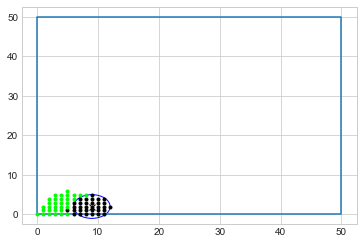

In [35]:
plot_population()

2.52 %
0:00:01.301135


True

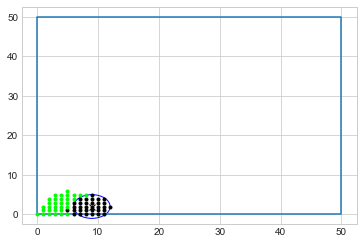

In [36]:
population.sort(key=lambda x: x.fitness, reverse=True)
if members_per_generation > 1:
    kill_off_the_weak()
check_for_fittest()

In [37]:
reset_population()
if members_per_generation > 1:
    #mingle_the_genes()
    asexually_reproduce()

In [38]:
mutate_population()

In [39]:
#check_coverage_population()

0 [356]
14.24 %
0:00:03.111484
1 [165]
2 [173]
3 [308]
4 [50]
5 [270]
6 [76]
7 [638]
25.52 %
0:00:08.356869
8 [86]
9 [96]
10 [79]
11 [47]
12 [215]
13 [41]
14 [418]
15 [515]
16 [601]
17 [485]
18 [475]
19 [477]
20 [87]
21 [80]
22 [1011]
40.44 %
0:00:19.167798
23 [877]
24 [470]
25 [426]
26 [762]
27 [644]
28 [653]
29 [139]
30 [354]
31 [279]
32 [662]
33 [692]
34 [457]
35 [1123]
44.92 %
0:00:29.087694
36 [1032]
37 [774]
38 [477]
39 [400]
40 [522]
41 [712]
42 [748]
43 [347]
44 [594]
45 [950]
46 [1230]
49.2 %
0:00:38.660865
47 [916]
48 [953]
49 [1163]
50 [1044]
51 [467]
52 [912]
53 [1275]
51.0 %
0:00:45.921844
54 [1255]
55 [751]
56 [801]
57 [467]
58 [1433]
57.32000000000001 %
0:00:53.088785
59 [1834]
73.36 %
0:00:59.069655
60 [1472]
61 [1297]
62 [1803]
63 [1487]
64 [1615]
65 [1389]
66 [1235]
67 [1584]
68 [1805]
69 [1598]
70 [1881]
75.24 %
0:01:11.316778
71 [1036]
72 [952]
73 [1358]
74 [1501]
75 [1837]
76 [1490]
77 [1558]
78 [1060]
79 [1700]
80 [813]
81 [871]
82 [1697]
83 [779]
84 [574]
85 [755

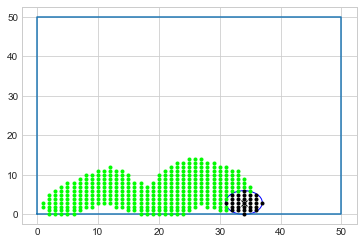

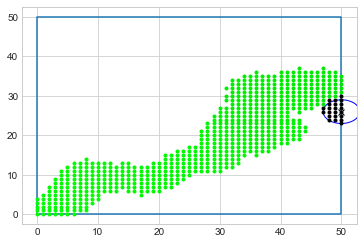

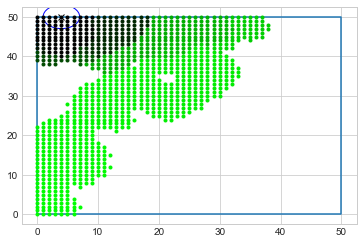

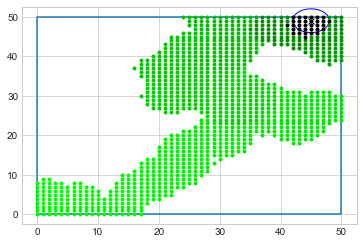

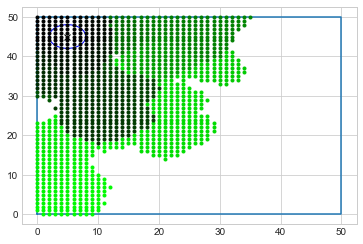

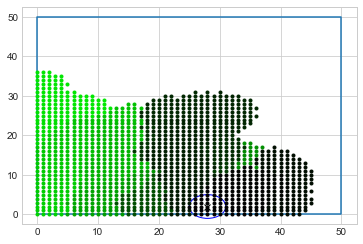

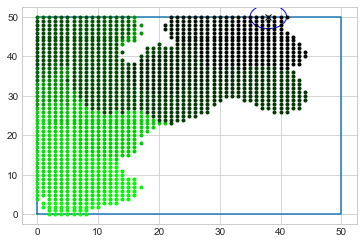

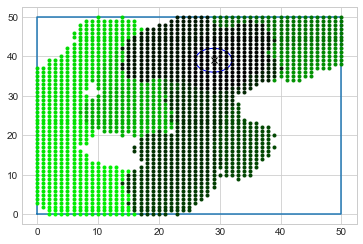

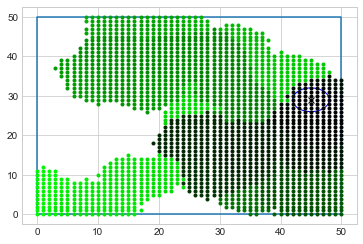

In [40]:
if members_per_generation > 1:
    for i in range(0, generations):
        print(i, end=" ")
        smart_scatter()
        #hard_coded_search()
        population.sort(key=lambda x: x.fitness, reverse=True)
        print(population)
        kill_off_the_weak()
        is_new_fittest = check_for_fittest()
        #mingle_the_genes()
        asexually_reproduce()
        if not is_new_fittest:
            population.append(copy.deepcopy(fittest_swarm))
        reset_population()
        mutate_population()
        check_coverage_population()
else:
    for i in range(0, generations):
        print(i, end=" ")
        smart_scatter()
        #hard_coded_search()
        population.sort(key=lambda x: x.fitness, reverse=True)
        print(population)
        check_for_fittest()
        reset_population()
        mutate_population()

In [41]:
print(datetime.datetime.now() - start_time)

0:01:47.666519


75.24 %


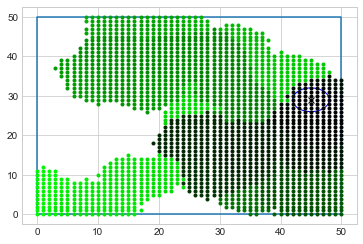

In [42]:
#check_drone_coverage(fittest_swarm)
draw_scene(fittest_swarm)